In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
st = pd.read_csv('data/studentInfo.csv')

In [3]:
st.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


**StudentInfo Dataset description**
* There are 32953 rows in the dataset, but only **28785 unique students**
* 52% of students are male, 48% of students are female
* 84% of students level of education is A level or below
* 70% of student are 35 or under, 29% is between 35 and 55, the remaining 1% is above the age of 55 
* 10% of students have a disability

Due to some student repeating modules, for the initial demographic analysis I will remove their duplicate information and only keep one record per student.

In [4]:
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
code_module             32593 non-null object
code_presentation       32593 non-null object
id_student              32593 non-null int64
gender                  32593 non-null object
region                  32593 non-null object
highest_education       32593 non-null object
imd_band                31482 non-null object
age_band                32593 non-null object
num_of_prev_attempts    32593 non-null int64
studied_credits         32593 non-null int64
disability              32593 non-null object
final_result            32593 non-null object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [5]:
#dropping multiple records from the dataset
st_clean = pd.DataFrame.drop_duplicates (st, subset = 'id_student')

M    0.522703
F    0.477297
Name: gender, dtype: float64

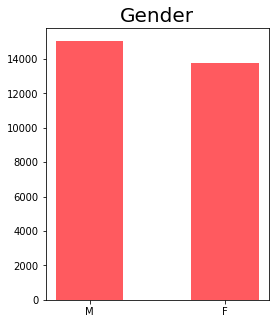

In [6]:
def plot_cat_var(column,title,size=(10,6)):
    new_d = dict(column.value_counts())
    d_keys = list(new_d.keys())
    d_values = list(new_d.values())

    plt.figure(figsize=size)
    plt.bar(d_keys, d_values,color='#ff5a5f', width=0.5)
    plt.title(title,fontsize=20)

plot_cat_var(st_clean.gender,'Gender',size=(4,5))
st_clean.gender.value_counts(normalize=True)

A Level or Equivalent          0.429217
Lower Than A Level             0.409241
HE Qualification               0.142157
No Formal quals                0.010631
Post Graduate Qualification    0.008755
Name: highest_education, dtype: float64

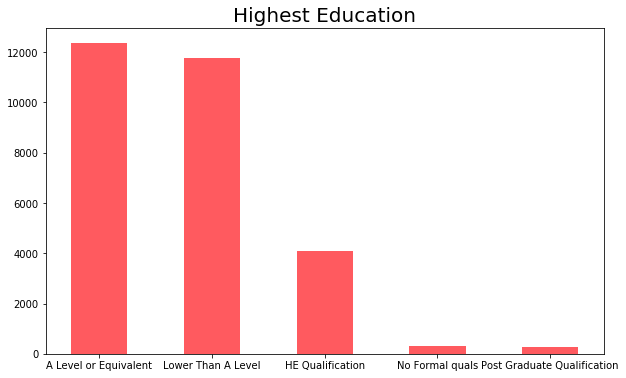

In [7]:
plot_cat_var(st_clean.highest_education,'Highest Education')
st_clean.highest_education.value_counts(normalize=True)

0-35     0.699844
35-55    0.293973
55<=     0.006184
Name: age_band, dtype: float64

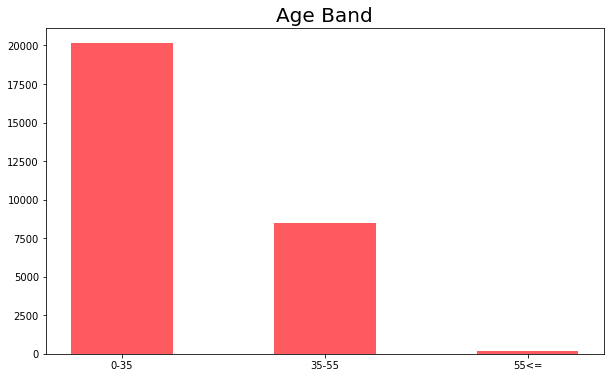

In [8]:
plot_cat_var(st_clean.age_band,'Age Band')
st_clean.age_band.value_counts(normalize=True)

N    0.905611
Y    0.094389
Name: disability, dtype: float64

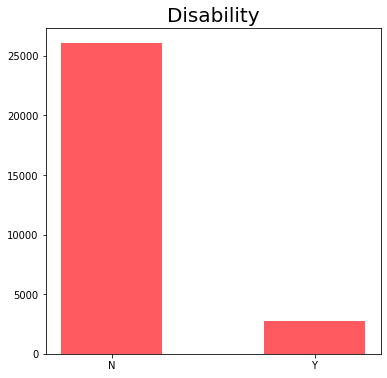

In [9]:
plot_cat_var(st_clean.disability,'Disability',size=(6,6))
st_clean.disability.value_counts(normalize=True)

**Final Results**
* 38% of students have finished their modules + 10% with a distinction
* 31% have withdrawn from a module
* 21% of students failed
* OPTION OF ANALYSIS - DOES THE AMOUNT OF INTERACTIONS EFFECT OF GETTING A DISTINCTION?

Pass           0.376342
Withdrawn      0.314157
Fail           0.217613
Distinction    0.091888
Name: final_result, dtype: float64

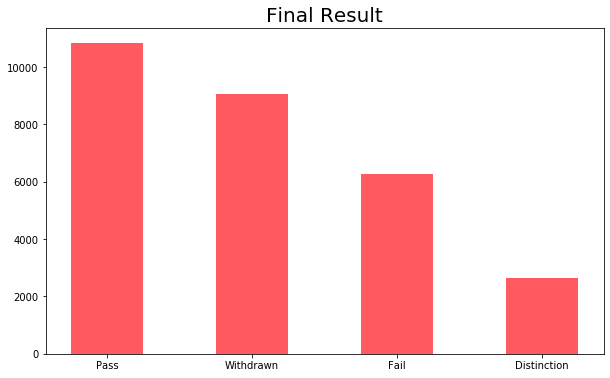

In [10]:
plot_cat_var(st_clean.final_result,'Final Result')
st_clean.final_result.value_counts(normalize=True)

In [11]:
st.loc[st['final_result'] == 'Distinction'] = 'Pass'

### VLE Dataset

In [12]:
vle = pd.read_csv('data/studentVle.csv')

In [13]:
vle.head()
#this datasetset has no missing values

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [14]:
#26074 unique students have interacted with the VLE
#but there are 28785 unique students - it seems like there might be 2711 students who have not used
#the VLE

In [15]:
len(vle.id_student.unique())
unique_vle_students = list(vle.id_student.unique())
unique_total_students = list(st_clean.id_student.unique())

In [16]:
#let's find you which students are not in the VLE table
unique_vle_students = set(vle.id_student)
unique_total_students = set(st_clean.id_student)

#this is a list of students who are not present in VLE df
students_not_in_vle = list(unique_total_students.difference(unique_vle_students))

#this is a dataframe with information about students who are not present in the VLE df
df_not_in_vle = st_clean[st_clean.id_student.isin(students_not_in_vle)]

Withdrawn    0.879749
Fail         0.119144
Pass         0.001107
Name: final_result, dtype: float64

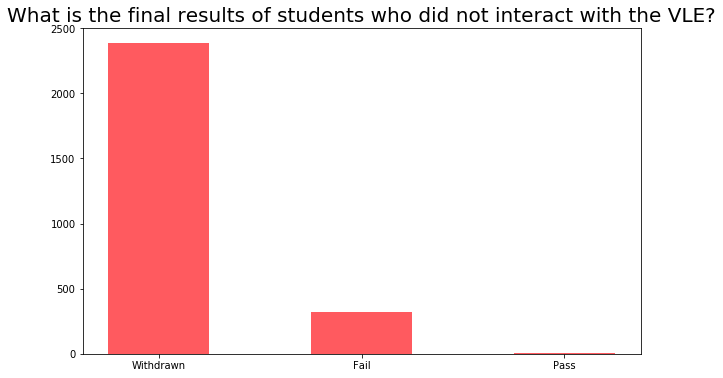

In [17]:
plot_cat_var(df_not_in_vle.final_result,'What is the final results of students who did not interact with the VLE?')
df_not_in_vle.final_result.value_counts(normalize=True)

In [18]:
# it seems like the students who have not the VLE at all have mostly withdrawn from the module
# this suggest that these are the students who have changed their mind
# however, here is 12% of students who failed their module in this dataset
# these students should be dropped from the dataset (?)

In [19]:
#removing student who did not interact with VLE from the dataset

#df of inactive students
#len - 2711
len(df_not_in_vle)
len(students_not_in_vle)

#this is now a df with only students who are also in the VLE table
st_actives = st[st['id_student'].isin(students_not_in_vle) == False]

#len = 29741
#number of unique students = 26074

In [20]:
len(students_not_in_vle)

2711

In [21]:
#to this df I would like to add - number of clicks per module/presentation

In [22]:
vle_for_joining = vle.drop(['id_site','date'],axis =1)

In [23]:
vle_for_joining.head()
#26074 unique students

,code_module,code_presentation,id_student,sum_click
0,AAA,2013J,28400,4
1,AAA,2013J,28400,1
2,AAA,2013J,28400,1
3,AAA,2013J,28400,11
4,AAA,2013J,28400,1


In [24]:
len(vle_for_joining)

10655280

In [25]:
vle_for_joining.isna().sum()

code_module          0
code_presentation    0
id_student           0
sum_click            0
dtype: int64

In [26]:
df_sum_click = vle_for_joining.groupby(['code_module', 'code_presentation','id_student']).agg({'sum_click': ['sum']})

In [27]:
df_sum_click.columns = ['sum_of_clicks']

In [28]:
df_sum_click_new_index = df_sum_click.reset_index()

In [29]:
df_sum_click_new_index.head()

,code_module,code_presentation,id_student,sum_of_clicks
0,AAA,2013J,11391,934
1,AAA,2013J,28400,1435
2,AAA,2013J,30268,281
3,AAA,2013J,31604,2158
4,AAA,2013J,32885,1034


In [30]:
df_sum_click_new_index.isna().sum()

code_module          0
code_presentation    0
id_student           0
sum_of_clicks        0
dtype: int64

In [31]:
st_actives.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [32]:
st_actives_with_vle = pd.merge(st_actives, df_sum_click_new_index,
                               how='left',
                               on=['code_module','code_presentation','id_student'])




In [33]:
st_actives_with_vle.head()
#this df now contains the total number of clicks per module and presentation!!

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_of_clicks
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0


In [34]:
len(st_actives_with_vle)

29741

In [35]:
len(st_actives_with_vle.id_student.unique())

23510

In [36]:
st_actives_with_vle.isna().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                 865
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
sum_of_clicks           3537
dtype: int64

In [37]:
st_actives_with_vle.loc[st_actives_with_vle.sum_of_clicks.isna() == True]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_of_clicks
43,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,NaN
78,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,NaN
87,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,NaN
115,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,NaN
124,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29720,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,NaN
29727,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,NaN
29735,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,NaN
29737,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,Pass,NaN


In [38]:
#FIND OUT THE REASONS BEHIND THE MISSING VALUES - I WILL DROP THEM FOR NOW
st_actives_with_vle.dropna(inplace=True)

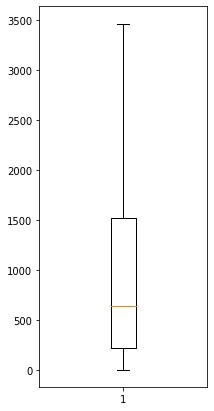

In [39]:
plt.figure(figsize=(3,7))
plt.boxplot(st_actives_with_vle.sum_of_clicks,showfliers=False);

In [40]:
st_actives_with_vle.sum_of_clicks.describe()

count    25349.000000
mean      1179.353623
std       1547.157049
min          1.000000
25%        217.000000
50%        633.000000
75%       1517.000000
max      24139.000000
Name: sum_of_clicks, dtype: float64

Distribution of clicks:
* Median - 717 clicks
* Mean - 1326
* this is a heavily skewed distribution due to the large number of outliers
* normalisation might help with outliers

In [41]:
#renaming df
df = st_actives_with_vle.copy()
df.rename(columns={"final_result": "target"}, inplace=True)

#### Dropping unneccesary columns

In [42]:
to_drop = ['id_student']
df.drop(to_drop, axis=1,inplace=True)

In [43]:
df.head()

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,target,sum_of_clicks
0,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0
1,AAA,2013J,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0
2,AAA,2013J,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0
3,AAA,2013J,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0
4,AAA,2013J,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0


In [44]:
#df.loc[df['target'] == 'Distinction'] = 'Pass'

In [45]:
type(df.target[2]) == type(df.target[0])

True

#### Creating dummy variables

In [46]:
#selecting categorical columns
cat_cols = ['code_module', 'code_presentation', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band','disability']

df = pd.get_dummies(data=df,columns = cat_cols)

In [47]:
df.head()

,num_of_prev_attempts,studied_credits,target,sum_of_clicks,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,...,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y
0,0,240,Pass,934.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
1,0,60,Pass,1435.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,60,Withdrawn,281.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,60,Pass,2158.0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
4,0,60,Pass,1034.0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


In [48]:
df.columns

Index(['num_of_prev_attempts', 'studied_credits', 'target', 'sum_of_clicks',
       'code_module_AAA', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013B', 'code_presentation_2013J',
       'code_presentation_2014B', 'code_presentation_2014J', 'gender_F',
       'gender_M', 'region_East Anglian Region', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'imd_band_0-10%',

In [49]:
df.rename(columns={'age_band_55<=': "55+"}, inplace=True)

#### Splitting dataset - training, validation, testing set

In [50]:
from sklearn.model_selection import train_test_split

#I am going to cut away a random 5% of the dataset for final testing.

X_testing_set = df.drop('target',axis=1)
y_testing_set = df.target

#ts = 'TESTING SET'
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(X_testing_set, y_testing_set, test_size=0.05, random_state=123)

In [51]:
#putting my df back together
df = pd.concat([X_train_ts, y_train_ts],axis=1)

The following variables now contain the 5% testing set

df validation set:
   * y_test_ts - labels
   * X_test_ts - data

Creating the validation set (10% of data)

In [52]:
X = df.drop('target',axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

### Tackling class imbalace

Pass         0.466550
Withdrawn    0.274283
Fail         0.259167
Name: target, dtype: float64

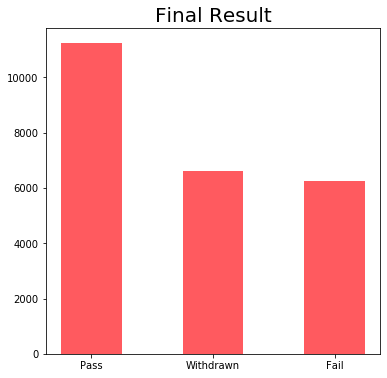

In [53]:
plot_cat_var(df.target,'Final Result',size=(6,6))
df.target.value_counts(normalize=True)

In [54]:
#to avoid data leakage when using SMOTE, I have split the data beforehand

from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=12)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [56]:
#putting upsampled dataset back together
X_train = pd.DataFrame(X_train, columns=X_train_ts.columns)
y_train = pd.Series(y_train)

df = pd.concat([X_train,y_train],axis=1)

In [57]:
df.rename(columns={0: "target"}, inplace=True)

In [58]:
df.shape

(30318, 50)

In [59]:
df.head()

,num_of_prev_attempts,studied_credits,sum_of_clicks,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,...,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_0-35,age_band_35-55,55+,disability_N,disability_Y,target
0,0,120,1921.0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,Pass
1,0,60,2445.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,Pass
2,0,30,1420.0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,Pass
3,0,180,3264.0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,Pass
4,0,60,582.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,Withdrawn


Fail         0.333333
Pass         0.333333
Withdrawn    0.333333
Name: target, dtype: float64

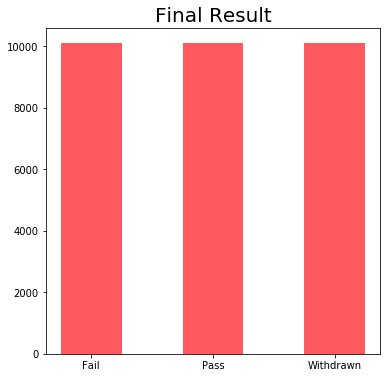

In [60]:
plot_cat_var(df.target,'Final Result',size=(6,6))
df.target.value_counts(normalize=True)

In [61]:
X_train.columns

Index(['num_of_prev_attempts', 'studied_credits', 'sum_of_clicks',
       'code_module_AAA', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013B', 'code_presentation_2013J',
       'code_presentation_2014B', 'code_presentation_2014J', 'gender_F',
       'gender_M', 'region_East Anglian Region', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'imd_band_0-10%',
       'i

## Modelling

In [62]:
#importing libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

#import stats_for_classification as stats
from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib.pylab as pl
import xgboost

In [63]:
#PCA compression
#scaling data for PCA
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train))

In [66]:
pca_1 = PCA(n_components=45)

principalComponents = pca_1.fit_transform(scaled_X_train)

In [67]:
#looking at explained variance ratio of different number of components
print(np.sum(pca_1.explained_variance_ratio_))

0.9932916475233272


In [68]:
#baseline model without gridsearch
pipe_baseline = Pipeline([('scl', MinMaxScaler()),
                  ('pca', PCA(n_components=45)),
                  ('clf', RandomForestClassifier(random_state = 123))])

pipe_baseline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scl', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=45,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                       

In [69]:
print('Training score: :'+str(pipe_baseline.score(X_train,y_train)))
print('Testing score: :'+str(pipe_baseline.score(X_test,y_test)))

Training score: :0.999835081469754
Testing score: :0.48941469489414696


In [70]:
#let's try this model with gridsearch
pipe_baseline_grid = Pipeline([('scl', MinMaxScaler()),
                  ('pca', PCA(n_components=45)),
                  ('clf', RandomForestClassifier(random_state = 123,n_jobs=6))])

# Set grid search params
param_baseline_grid = [ 
  {'clf__n_estimators': [40,50,70],
   'clf__criterion': ['gini','entropy'], 
   'clf__max_depth': [10,15,20],  
   'clf__min_samples_leaf':[0.02,0.002],  
  }]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_baseline_grid,
            param_grid=param_baseline_grid,
            scoring='accuracy',
            cv=3, verbose=True, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.5min finished


Best accuracy: 0.510

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_leaf': 0.002, 'clf__n_estimators': 40}


In [71]:
print('Training score: :'+str(gs_rf.score(X_train,y_train)))
print('Testing score: :'+str(gs_rf.score(X_test,y_test)))

Training score: :0.6149482155815027
Testing score: :0.5330012453300125


In [ ]:
#Best accuracy: 0.435
#Best params:
 #{'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_leaf': 0.002, 'clf__n_estimators': 70}
    
    



In [72]:
predictions_grid_rf = gs_rf.predict(X_test)

confusion_matrix(y_test,predictions_grid_rf)

array([[ 79, 435, 130],
       [ 45, 978, 106],
       [ 34, 375, 227]], dtype=int64)

In [ ]:
#Instantiate XGBClassifier
#xgb_cl_pipeline = XGBClassifier(nthread=5)


#xgb_baseline_grid = Pipeline([('scl', MinMaxScaler()),
             #    ('pca', PCA(n_components=40)),
             #    ('clf', xgb_cl_pipeline)])

# Set grid search params
#param_grid_xgb = {
 #   'learning_rate': [0.1,0.2,0.3], #=eta, smaller number makes model more robust by shrinking weights on each step
 #   'max_depth': [20,30,40,50], #max depth of a three, controls over-fitting
 #   'min_child_weight': [40,60,80], #minimum sum of weights of all observations required in a child, higher values reduce over-fitting
 #  'subsample': [0.2,0.5], #the fraction of observations to be randomly samples for each tree.
 #   'n_estimators': [30,50,60,70],
#}


#grid_xgb = GridSearchCV(xgb_cl_pipeline, param_grid_xgb, scoring='accuracy', cv=None, n_jobs=1)
#grid_xgb.fit(X_train, y_train)

#best_parameters = grid_xgb.best_params_

#print('Grid Search found the following optimal parameters: ')
#for param_name in sorted(best_parameters.keys()):
#    print('%s: %r' % (param_name, best_parameters[param_name]))

#training_preds = grid_xgb.predict(X_train)
#test_preds = grid_xgb.predict(X_test)
#training_accuracy = accuracy_score(y_train, training_preds)
#test_accuracy = accuracy_score(y_test, test_preds)

#print('')
#print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
#print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
#Grid Search found the following optimal parameters: 
#learning_rate: 0.2
#max_depth: 30
#min_child_weight: 60
#n_estimators: 50
#subsample: 0.5

#Training Accuracy: 63.73%
#Validation accuracy: 60.96%



#Grid Search found the following optimal parameters: 
#learning_rate: 0.2
#max_depth: 20
#min_child_weight: 80
#n_estimators: 50
#subsample: 0.5

#Training Accuracy: 69.57%
#Validation accuracy: 66.33%


#Grid Search found the following optimal parameters: 
#learning_rate: 0.1
#max_depth: 30
#min_child_weight: 40
#n_estimators: 70
#subsample: 0.5

#Training Accuracy: 70.81%
#Validation accuracy: 66.71%


#Grid Search found the following optimal parameters: 
#learning_rate: 0.1
#max_depth: 30
#min_child_weight: 35
#n_estimators: 80
#subsample: 0.5

#Training Accuracy: 71.89%
#Validation accuracy: 66.83%

In [74]:
X_train = X_train.astype(int)
X_test = X_test.astype(int)

In [78]:
#Instantiate XGBClassifier
xgb_cl_pipeline = XGBClassifier(nthread=6)


xgb_baseline_grid = Pipeline([('scl', MinMaxScaler()),
                 ('pca', PCA(n_components=40)),
                 ('clf', xgb_cl_pipeline)])

# Set grid search params
param_grid_xgb = {
    'learning_rate': [0.1], #=eta, smaller number makes model more robust by shrinking weights on each step
    'max_depth': [40], #max depth of a three, controls over-fitting
    'min_child_weight': [15], #minimum sum of weights of all observations required in a child, higher values reduce over-fitting
   'subsample': [0.5], #the fraction of observations to be randomly samples for each tree.
    'n_estimators': [100,130],
}


grid_xgb = GridSearchCV(xgb_cl_pipeline, param_grid_xgb, scoring='accuracy', cv=None, n_jobs=1)
grid_xgb.fit(X_train, y_train)

best_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_xgb.predict(X_train)
test_preds = grid_xgb.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 40
min_child_weight: 15
n_estimators: 130
subsample: 0.5

Training Accuracy: 84.57%
Validation accuracy: 65.01%


In [ ]:
#result resampled with three classes

#Grid Search found the following optimal parameters: 
#learning_rate: 0.1
#max_depth: 30
#min_child_weight: 35
#n_estimators: 80
#subsample: 0.5

#Training Accuracy: 74.36%
#Validation accuracy: 65.84%



#Grid Search found the following optimal parameters: 
#learning_rate: 0.2
#max_depth: 40
#min_child_weight: 20
#n_estimators: 80
#subsample: 0.5

#Training Accuracy: 82.46%
#Validation accuracy: 64.8%


#Grid Search found the following optimal parameters: 
#learning_rate: 0.1
#max_depth: 40
#min_child_weight: 15
#n_estimators: 100
#subsample: 0.5

#Training Accuracy: 82.41%
#Validation accuracy: 65.3%

In [ ]:
#creating a df with the total number of clicks in VLE per student
df_sum_click = vle.groupby('id_student').sum()
df_sum_click.drop(['id_site','date'], axis=1, inplace=True)

In [ ]:
df_sum_click.head()

In [ ]:
#I will now join this table with the main table of students

In [ ]:
st_with_total_clicks = st_clean.set_index('id_student')

In [ ]:
st_with_total_clicks = st_with_total_clicks.join(df_sum_click)

In [ ]:
st_with_total_clicks.isna().sum()

In [ ]:
st_with_total_clicks.sum_click = st_with_total_clicks.sum_click.dropna()

In [ ]:
len(st_with_total_clicks)

In [ ]:
#now we have a dataframe with all students including their total number of VLE interactions
st_with_total_clicks.sum_click.describe()

**How much do students interact with the VLE?**
* mean number of clicks (across all modules): 1375
* median number of clicks (across all modules): 686
* the large difference between the mean and the median is caused by heavily skewed data
* student with the highest number of clicks: 28615

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(st_with_total_clicks.sum_click, bins=100);

In [ ]:
#try plotting average grade with num_clicks

In [ ]:
assessment = pd.read_csv('data/studentAssessment.csv')

In [ ]:
assessment.head()

In [ ]:
assessment.dropna(inplace=True)

In [ ]:
assessment.isna().sum()

In [ ]:
len(assessment)

In [ ]:
assessment = assessment.groupby('id_student').median()

In [ ]:
assessment.drop(['id_assessment','date_submitted','is_banked'],axis=1, inplace=True)

In [ ]:
assessment.head()

In [ ]:
st_with_total_clicks = st_with_total_clicks.join(assessment)

In [ ]:
st_with_total_clicks.head()

In [ ]:
st_with_total_clicks.isna().sum()

In [ ]:
len(st_with_total_clicks)

In [ ]:
#INVESTIGATE WHY THE DIFFERENCE - WHY IS THERE SMALLER NUMBER OF STUDENTS IN ASSESSMENT THAN IN 
#TOTAL TABLE

In [ ]:
plt.figure(figsize=(14,10))
plt.scatter(st_with_total_clicks.sum_click, st_with_total_clicks.score, alpha = 0.1)

In [ ]:
# Get names of indexes for which column Age has value 30
indexNames = st_with_total_clicks[st_with_total_clicks['sum_click'] > 2000].index
 
# Delete these row indexes from dataFrame
st_with_total_clicks_no_high_clicks = st_with_total_clicks.drop(indexNames)

In [ ]:
plt.figure(figsize=(14,10))
plt.scatter(st_with_total_clicks_no_high_clicks.sum_click, st_with_total_clicks_no_high_clicks.score, alpha = 0.1)

In [ ]:
#preparing dataset for baseline model
#classification model, goal: labels modules where particular student is likely to fail,
#withdraw, pass, or pass with distinction
#module oriented dataset- row = module with info about student


In [ ]:
original_assessment = pd.read_csv('data/studentAssessment.csv')

In [ ]:
assessment.head()

In [ ]:
original_assessment.head()

In [ ]:
assess_info = pd.read_csv('data/assessments.csv')

In [ ]:
assess_info.head()

In [ ]:
len(assess_info.code_module.unique())
#206 unique assessments

In [ ]:
st.head()

In [ ]:
len(st)

In [ ]:
len(st.id_student.unique())

In [ ]:
courses = pd.read_csv('data/courses.csv')

In [ ]:
courses

In [ ]:
st.head()


In [ ]:
st.code_module.unique()

In [ ]:
st['code_module'] = st['code_module'].replace({'AAA':'A','BBB':'B','CCC':'C','DDD':'D','EEE':'E','FFF':'F', 'GGG':'G'})

In [ ]:
st['code_presentation'] = st['code_presentation'].replace({'2013J':'2013OCT','2013B':'2013FEB','2014J':'2014OCT','2014B':'2014FEB'})

In [ ]:
st["module"] = st["code_module"] +'_'+ st["code_presentation"]

In [ ]:
st.head()

In [ ]:
st = st.drop(['code_module', 'code_presentation'],axis = 1)

In [ ]:
reg = pd.read_csv('data/studentRegistration.csv')

In [ ]:
len(reg)